In [ ]:
# Install necessary libraries
!pip install pandas beautifulsoup4 unidecode
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install nltk
!pip install scikit-learn matplotlib
!pip install seaborn
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.7 MB/s eta 0:00:00
2023-12-30 03:22:44.303845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-30 03:22:44.303928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-30 03:22:44.305469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-30 03:22:44.316065: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the

In [ ]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from sklearn.metrics import f1_score


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('/content/mail_data.csv')
# Print the first few rows of the DataFrame
print(df.head())

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
# Function to remove HTML tags using BeautifulSoup
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Function to remove accented characters using unidecode
def remove_accented_chars(text):
    return unidecode(text)

# Tokenization using spaCy
nlp = spacy.load('en_core_web_sm')
def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

# Remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Lemmatization using spaCy
def process_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if token.text.lower() not in stop_words]
    return ' '.join(lemmatized_tokens)


# Apply the functions to the relevant columns in your dataset
df['Message'] = df['Message'].apply(remove_html_tags)
df['Message'] = df['Message'].apply(remove_accented_chars)
df['Tokens'] = df['Message'].apply(tokenize_text)
df['Message'] = df['Message'].apply(remove_stopwords)
df['Message'] = df['Message'].apply(process_text)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Message'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

df = pd.concat([df, tfidf_df], axis=1)

<ipython-input-5-a40eea08969b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
df.to_csv('/content/cleaned_mail_data.csv', index=False)

# Load the cleaned dataset
data = pd.read_csv('/content/cleaned_mail_data.csv')

In [ ]:
data = pd.read_csv('/content/cleaned_mail_data.csv')
mail_data = df.where(pd.notnull(df), '')


mail_data.shape

(5572, 5003)

In [ ]:
# Map 'spam' to 0 and 'ham' to 1
df['Category'] = df['Category'].map({'spam': 0, 'ham': 1})

In [ ]:
# Separating the data as text and labels
X = df['Message']
Y = df['Category']
print(X)
print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=3)

print(X.shape)
print(X_train.shape)
print(X_test.shape)

0       go jurong point , crazy .. available bugis n g...
1                           ok lar ... joke wif u oni ...
2       free entry 2 wkly comp win FA Cup final tkts 2...
3             u dun say early hor ... u c already say ...
4               Nah not think go usf , live around though
                              ...                        
5567    2nd time try 2 contact u. U PS750 Pound prize ...
5568                           u b go esplanade fr home ?
5569                     pity , * mood . ... suggestion ?
5570    guy bitching act like have interested buy some...
5571                                     rofl . true name
Name: Message, Length: 5572, dtype: object
0       1
1       1
2       0
3       1
4       1
       ..
5567    0
5568    1
5569    1
5570    1
5571    1
Name: Category, Length: 5572, dtype: int64
(5572,)
(4179,)
(1393,)


In [ ]:
# Use the pre-processed TF-IDF features for training
X_train_features = tfidf_matrix[:len(X_train)]
X_test_features = tfidf_matrix[len(X_train):]


Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')

print(X_train_features)


  (0, 4684)	0.23080957179362685
  (0, 910)	0.352984548268151
  (0, 761)	0.3988639846981077
  (0, 1897)	0.352984548268151
  (0, 4856)	0.2801005098559207
  (0, 1564)	0.2299590725349996
  (0, 763)	0.352984548268151
  (0, 539)	0.3125232805975714
  (0, 1031)	0.31772598987622713
  (0, 2649)	0.28962408931229766
  (1, 2355)	0.5613361847409486
  (1, 4775)	0.443246473067317
  (1, 1833)	0.4844061035550776
  (1, 1909)	0.41931555477845894
  (1, 2347)	0.27921218485818383
  (2, 40)	0.2391408986400467
  (2, 488)	0.17024202098727478
  (2, 2975)	0.16446892334523747
  (2, 4384)	0.12575398185065256
  (2, 3787)	0.200262429643017
  (2, 2928)	0.1679356627978799
  (2, 3018)	0.16512883349109414
  (2, 332)	0.22481485163771248
  (2, 4100)	0.12150121958703766
  (2, 157)	0.2310728873658881
  :	:
  (4173, 3660)	0.6963521052482844
  (4174, 4799)	0.41400761096995187
  (4174, 4277)	0.38588840906835714
  (4174, 1761)	0.3732605288298709
  (4174, 2100)	0.3510596105643104
  (4174, 3087)	0.3547833386585376
  (4174, 1637)	0

In [ ]:
# Training the model
model = LogisticRegression()
model.fit(X_train_features, Y_train)

prediction_on_training_data = model.predict(X_train_features)
accuracy_on_training_data = accuracy_score(Y_train, prediction_on_training_data)
print('Accuracy on the training data:', accuracy_on_training_data)

prediction_on_test_data = model.predict(X_test_features)
accuracy_on_test_data = accuracy_score(Y_test, prediction_on_test_data)
print('Accuracy on the test data:', accuracy_on_test_data)

Accuracy on the training data: 0.8681502751854511
Accuracy on the test data: 0.8592964824120602


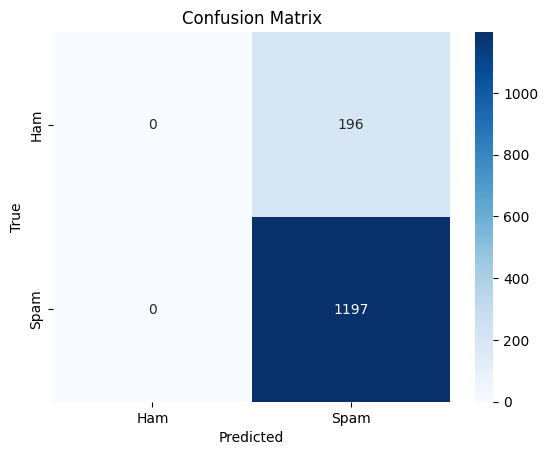

In [ ]:
# Evaluate the model and plot the confusion matrix
cm = confusion_matrix(Y_test, prediction_on_test_data)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Calculate F1 score
f1_test_data = f1_score(Y_test, prediction_on_test_data)
print('F1 Score on the test data:', f1_test_data)

F1 Score on the test data: 0.9243243243243243


In [ ]:
# Example: Predict whether a new email is spam or ham
user_input_email = input("Enter the new email text: ")
input_mail = [user_input_email]
input_mail_features = feature_extraction.transform(input_mail)

# Predict using the trained model
prediction = model.predict(input_mail_features)

# Display the prediction
print("Prediction for the new email:")
if prediction[0] == 1:
    print("Ham Mail")
else:
    print("Spam Mail")

In [ ]:
# Define the parameter search space for Bayesian optimization
param_space = {'C': (1e-6, 1e+6, 'log-uniform')}

# Bayesian optimization with Logistic Regression
bayes_search = BayesSearchCV(
    LogisticRegression(),
    param_space,
    n_iter=50,  # Adjust as needed
    random_state=3,
    n_jobs=-1,
    cv=5  # Number of cross-validation folds
)

In [ ]:
# Fit the Bayesian search on the training data
bayes_search.fit(X_train_features, Y_train)

# Get the best parameters from Bayesian optimization
best_params = bayes_search.best_params_

# Print the best parameters found
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_model = LogisticRegression(**best_params)
best_model.fit(X_train_features, Y_train)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Best Parameters: OrderedDict([('C', 1000000.0)])


LogisticRegression(C=1000000.0)

In [ ]:
# Evaluate the model on the test data
prediction_on_test_data_bayes = best_model.predict(X_test_features)
accuracy_on_test_data_bayes = accuracy_score(Y_test, prediction_on_test_data_bayes)
print('Enhanced Accuracy on the test data:', accuracy_on_test_data_bayes)

Enhanced Accuracy on the test data: 0.9849246231155779


In [ ]:
# Confusion matrix for Bayesian optimization
cm_bayes = confusion_matrix(Y_test, prediction_on_test_data_bayes)

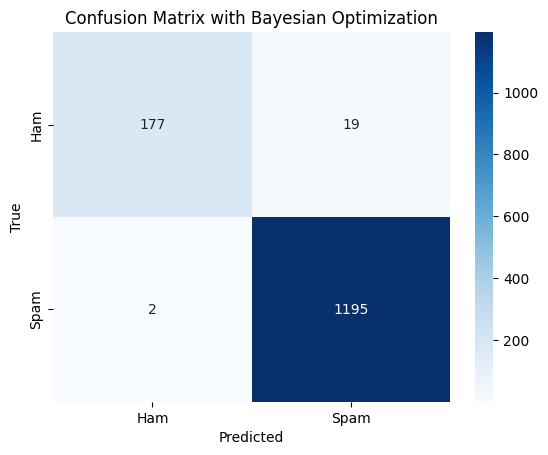

In [ ]:
# Plot the confusion matrix for Bayesian optimization
sns.heatmap(cm_bayes, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix with Bayesian Optimization")
plt.show()

In [ ]:
# Calculate F1 score for the optimized model
f1_test_data_bayes = f1_score(Y_test, prediction_on_test_data_bayes)
print('Enhanced F1 Score on the test data:', f1_test_data_bayes)


Enhanced F1 Score on the test data: 0.9912899211945251


In [ ]:
# Example: Predict whether a new email is spam or ham using the optimized model
user_input_email = input("Enter the new email text: ")
input_mail = [user_input_email]
input_mail_features = feature_extraction.transform(input_mail)

# Predict using the optimized model
prediction_bayes = best_model.predict(input_mail_features)

# Display the prediction
print("Prediction for the new email with Bayesian Optimization:")
if prediction_bayes[0] == 1:
    print("Ham Mail")
else:
    print("Spam Mail")

Enter the new email text: Todays Voda numbers ending 7548 are selected to receive a $350 award. If you have a match please call 08712300220 quoting claim code 4041 standard rates app
Prediction for the new email with Bayesian Optimization:
Spam Mail
